In [1]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt
from utils.data_helper import CustomDataset
    
import numpy as np
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster as cluster

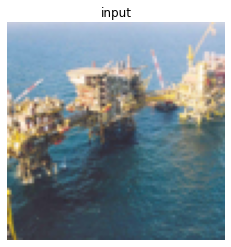

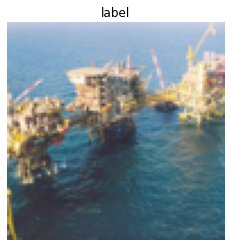

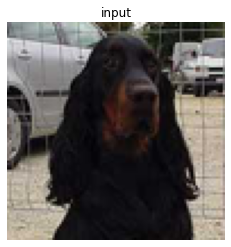

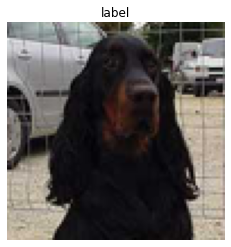

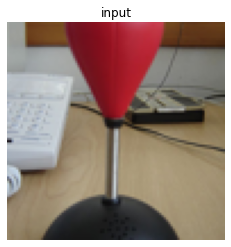

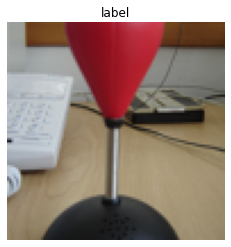

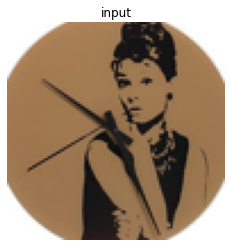

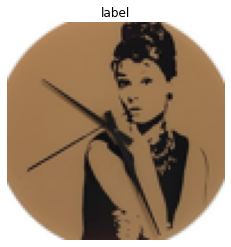

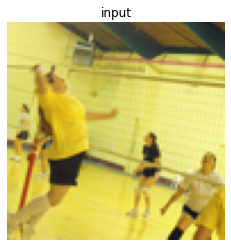

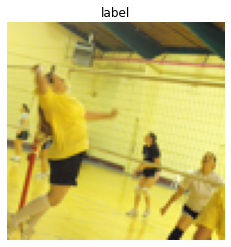

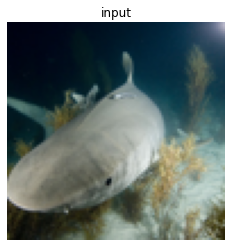

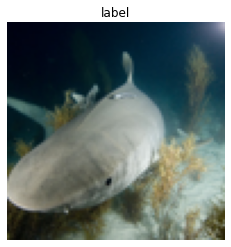

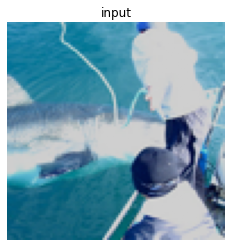

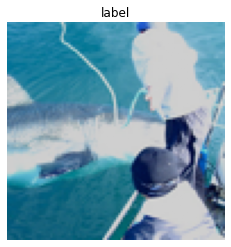

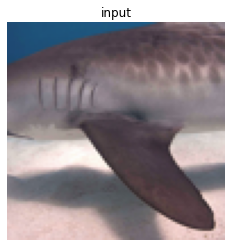

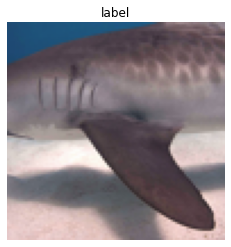

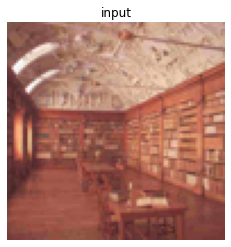

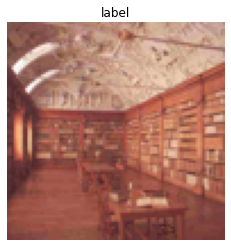

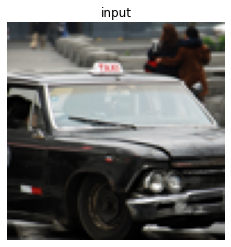

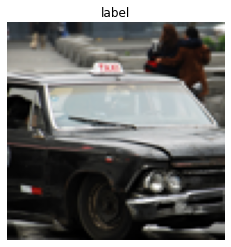

In [5]:
batch_size = 256;
def show_normalized_image(img, title=None, normalize=False):
    if normalize:
        plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
    else: 
        plt.imshow(img.detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    
train_transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.functional.to_grayscale()
        #transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
        #transforms.RandomRotation(20),
        #transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
        transforms.ToTensor(),  # convert PIL to Pytorch Tensor
        #normalize,
    ])


trainset = CustomDataset(root='./dataset', split="unlabeled", transform=train_transform)
#trainset, validset = torch.utils.data.random_split(trainset, [25600, len(trainset)-25600], generator=torch.Generator().manual_seed(42))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=4)
for epoch in range(1):
    running_loss = 0.0
    count =0;
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        count +=1
        plt.figure()
        show_normalized_image(inputs[0], 'input')
        #print(labels.shape)
        plt.figure()
        show_normalized_image(labels[0], 'label')
        if count ==10:
            break;


In [10]:
dataset_length = len(trainset)
idxs_unlabeled = np.arange(dataset_length)

In [14]:
def get_embedding(Dataloader, net):
    embedding = torch.zeros([dataset_length, 512])
    with torch.no_grad():
        for i, batch in enumerate(trainloader):
            x_in = batch[0].to(device=device)
            e1 = net(x_in)
            embedding[i*batch_size:(i+1)*batch_size] = e1.cpu()
            if(i%100)==0:
                print(i*batch_size/dataset_length)
    return embedding

#get the desired samples
def kmeans_greed_query(samples_desired, embedding):
    embedding = embedding.numpy()
    #The lb_flag is only useful for keeping track of which values are labeled
    #If you can ask for data multiple times. As is it doesn't matter.

    cluster_learner = KMeans(n_clusters=samples_desired,  max_iter=20)
    cluster_learner.fit(embedding)
    cluster_idxs = cluster_learner.predict(embedding)
    centers = cluster_learner.cluster_centers_[cluster_idxs]
    dis = (embedding - centers)**2
    dis = dis.sum(axis=1)
    q_idxs = np.array([np.arange(embedding.shape[0])[cluster_idxs==i][dis[cluster_idxs==i].argmin()] for i in range(n)])

    return idxs_unlabeled[q_idxs] ,

In [15]:
net = models.resnet34(pretrained=True).to(device=device)
net.fc = nn.Identity()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
embed = get_embedding(trainloader, net)
np.save('embed_info_512', embed, allow_pickle=True, fix_imports=True)

0.0


KeyboardInterrupt: 

In [63]:
embed = np.load('embed_info.npy')
print(embed.shape)

(512000, 512)


In [71]:
embed = np.load('embed_info.npy')
# = embed[:100000]
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(embed)
compress = pca.transform(embed)

In [72]:
print(pca.singular_values_)

[5689.0576 3164.0825 2892.839  2657.5808 2546.2437 2343.259  2306.7354
 2256.4883 2197.4424 2183.5347 2169.119  2097.747  2065.805  2026.4106
 1974.2941 1965.7205 1946.6432 1923.146  1896.8629 1869.9209 1850.1201
 1811.5835 1797.4222 1766.8334 1758.7844 1731.4751 1723.421  1699.6749
 1683.489  1681.5067 1647.9998 1626.5865 1618.1226 1605.2614 1596.9673
 1566.8522 1559.1045 1543.0752 1533.8887 1529.9299]


In [73]:
np.save('comp_info_40', compress, allow_pickle=True, fix_imports=True)


In [43]:
compress = np.load('comp_info_100.npy')

In [74]:
print(compress.shape)

(512000, 40)


In [75]:
samples_desired = 12800
embedding = compress#.numpy()
#The lb_flag is only useful for keeping track of which values are labeled
#If you can ask for data multiple times. As is it doesn't matter.
cluster_learner = cluster.MiniBatchKMeans(n_clusters=samples_desired,  max_iter=100, batch_size=100000, verbose=True)
cluster_learner.fit(embedding)
cluster_idxs = cluster_learner.predict(embedding)
centers = cluster_learner.cluster_centers_[cluster_idxs]
dis = (embedding - centers)**2
dis = dis.sum(axis=1)

Init 1/3 with method: k-means++
Inertia for init 1/3: 29653918.000000
Init 2/3 with method: k-means++
Inertia for init 2/3: 29657554.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 29664086.000000
Minibatch iteration 1/600: mean batch inertia: 107.463900, ewa inertia: 107.463900 
Minibatch iteration 2/600: mean batch inertia: 106.151490, ewa inertia: 106.951241 
Minibatch iteration 3/600: mean batch inertia: 104.988990, ewa inertia: 106.184738 
Minibatch iteration 4/600: mean batch inertia: 104.298640, ewa inertia: 105.447982 
Minibatch iteration 5/600: mean batch inertia: 103.680430, ewa inertia: 104.757534 
Minibatch iteration 6/600: mean batch inertia: 103.666090, ewa inertia: 104.331189 
Minibatch iteration 7/600: mean batch inertia: 102.578290, ewa inertia: 103.646464 
Minibatch iteration 8/600: mean batch inertia: 102.411080, ewa inertia: 103.163893 
Minibatch iteration 9/600: mean batch inertia: 102.209210, ewa inertia: 102.790971 
[MiniBatchKMeans] Reassigning 1766

Minibatch iteration 92/600: mean batch inertia: 99.341690, ewa inertia: 99.369215 
Minibatch iteration 93/600: mean batch inertia: 99.419380, ewa inertia: 99.388810 
Minibatch iteration 94/600: mean batch inertia: 99.341440, ewa inertia: 99.370306 
Minibatch iteration 95/600: mean batch inertia: 99.006790, ewa inertia: 99.228308 
Minibatch iteration 96/600: mean batch inertia: 99.165780, ewa inertia: 99.203883 
Minibatch iteration 97/600: mean batch inertia: 99.098850, ewa inertia: 99.162855 
Minibatch iteration 98/600: mean batch inertia: 99.313220, ewa inertia: 99.221591 
Minibatch iteration 99/600: mean batch inertia: 98.935470, ewa inertia: 99.109825 
Minibatch iteration 100/600: mean batch inertia: 99.614340, ewa inertia: 99.306901 
Minibatch iteration 101/600: mean batch inertia: 99.179030, ewa inertia: 99.256951 
Minibatch iteration 102/600: mean batch inertia: 99.276030, ewa inertia: 99.264404 
Minibatch iteration 103/600: mean batch inertia: 99.491780, ewa inertia: 99.353223 


In [76]:
q_idxs = np.array([np.arange(embedding.shape[0])[cluster_idxs==i][dis[cluster_idxs==i].argmin()] for i in range(12800)])

In [77]:
np.save('samples_reduced_40', q_idxs, allow_pickle=True, fix_imports=True)

In [65]:
print(q_idxs[0:10])

[206017 459288  11772 494435 207938 209085 361162 301003 474907 394411]


In [9]:
samples_10 = np.load('samples_reduced_10.npy')
samples_40 = np.load('samples_reduced_40.npy')

In [80]:
print(len(np.intersect1d(samples_40,samples_20 )))

933


In [3]:
print(samples_40[:10])

[106044  16544 499597 185245 137451 396488 437074  61515 204126 340717]


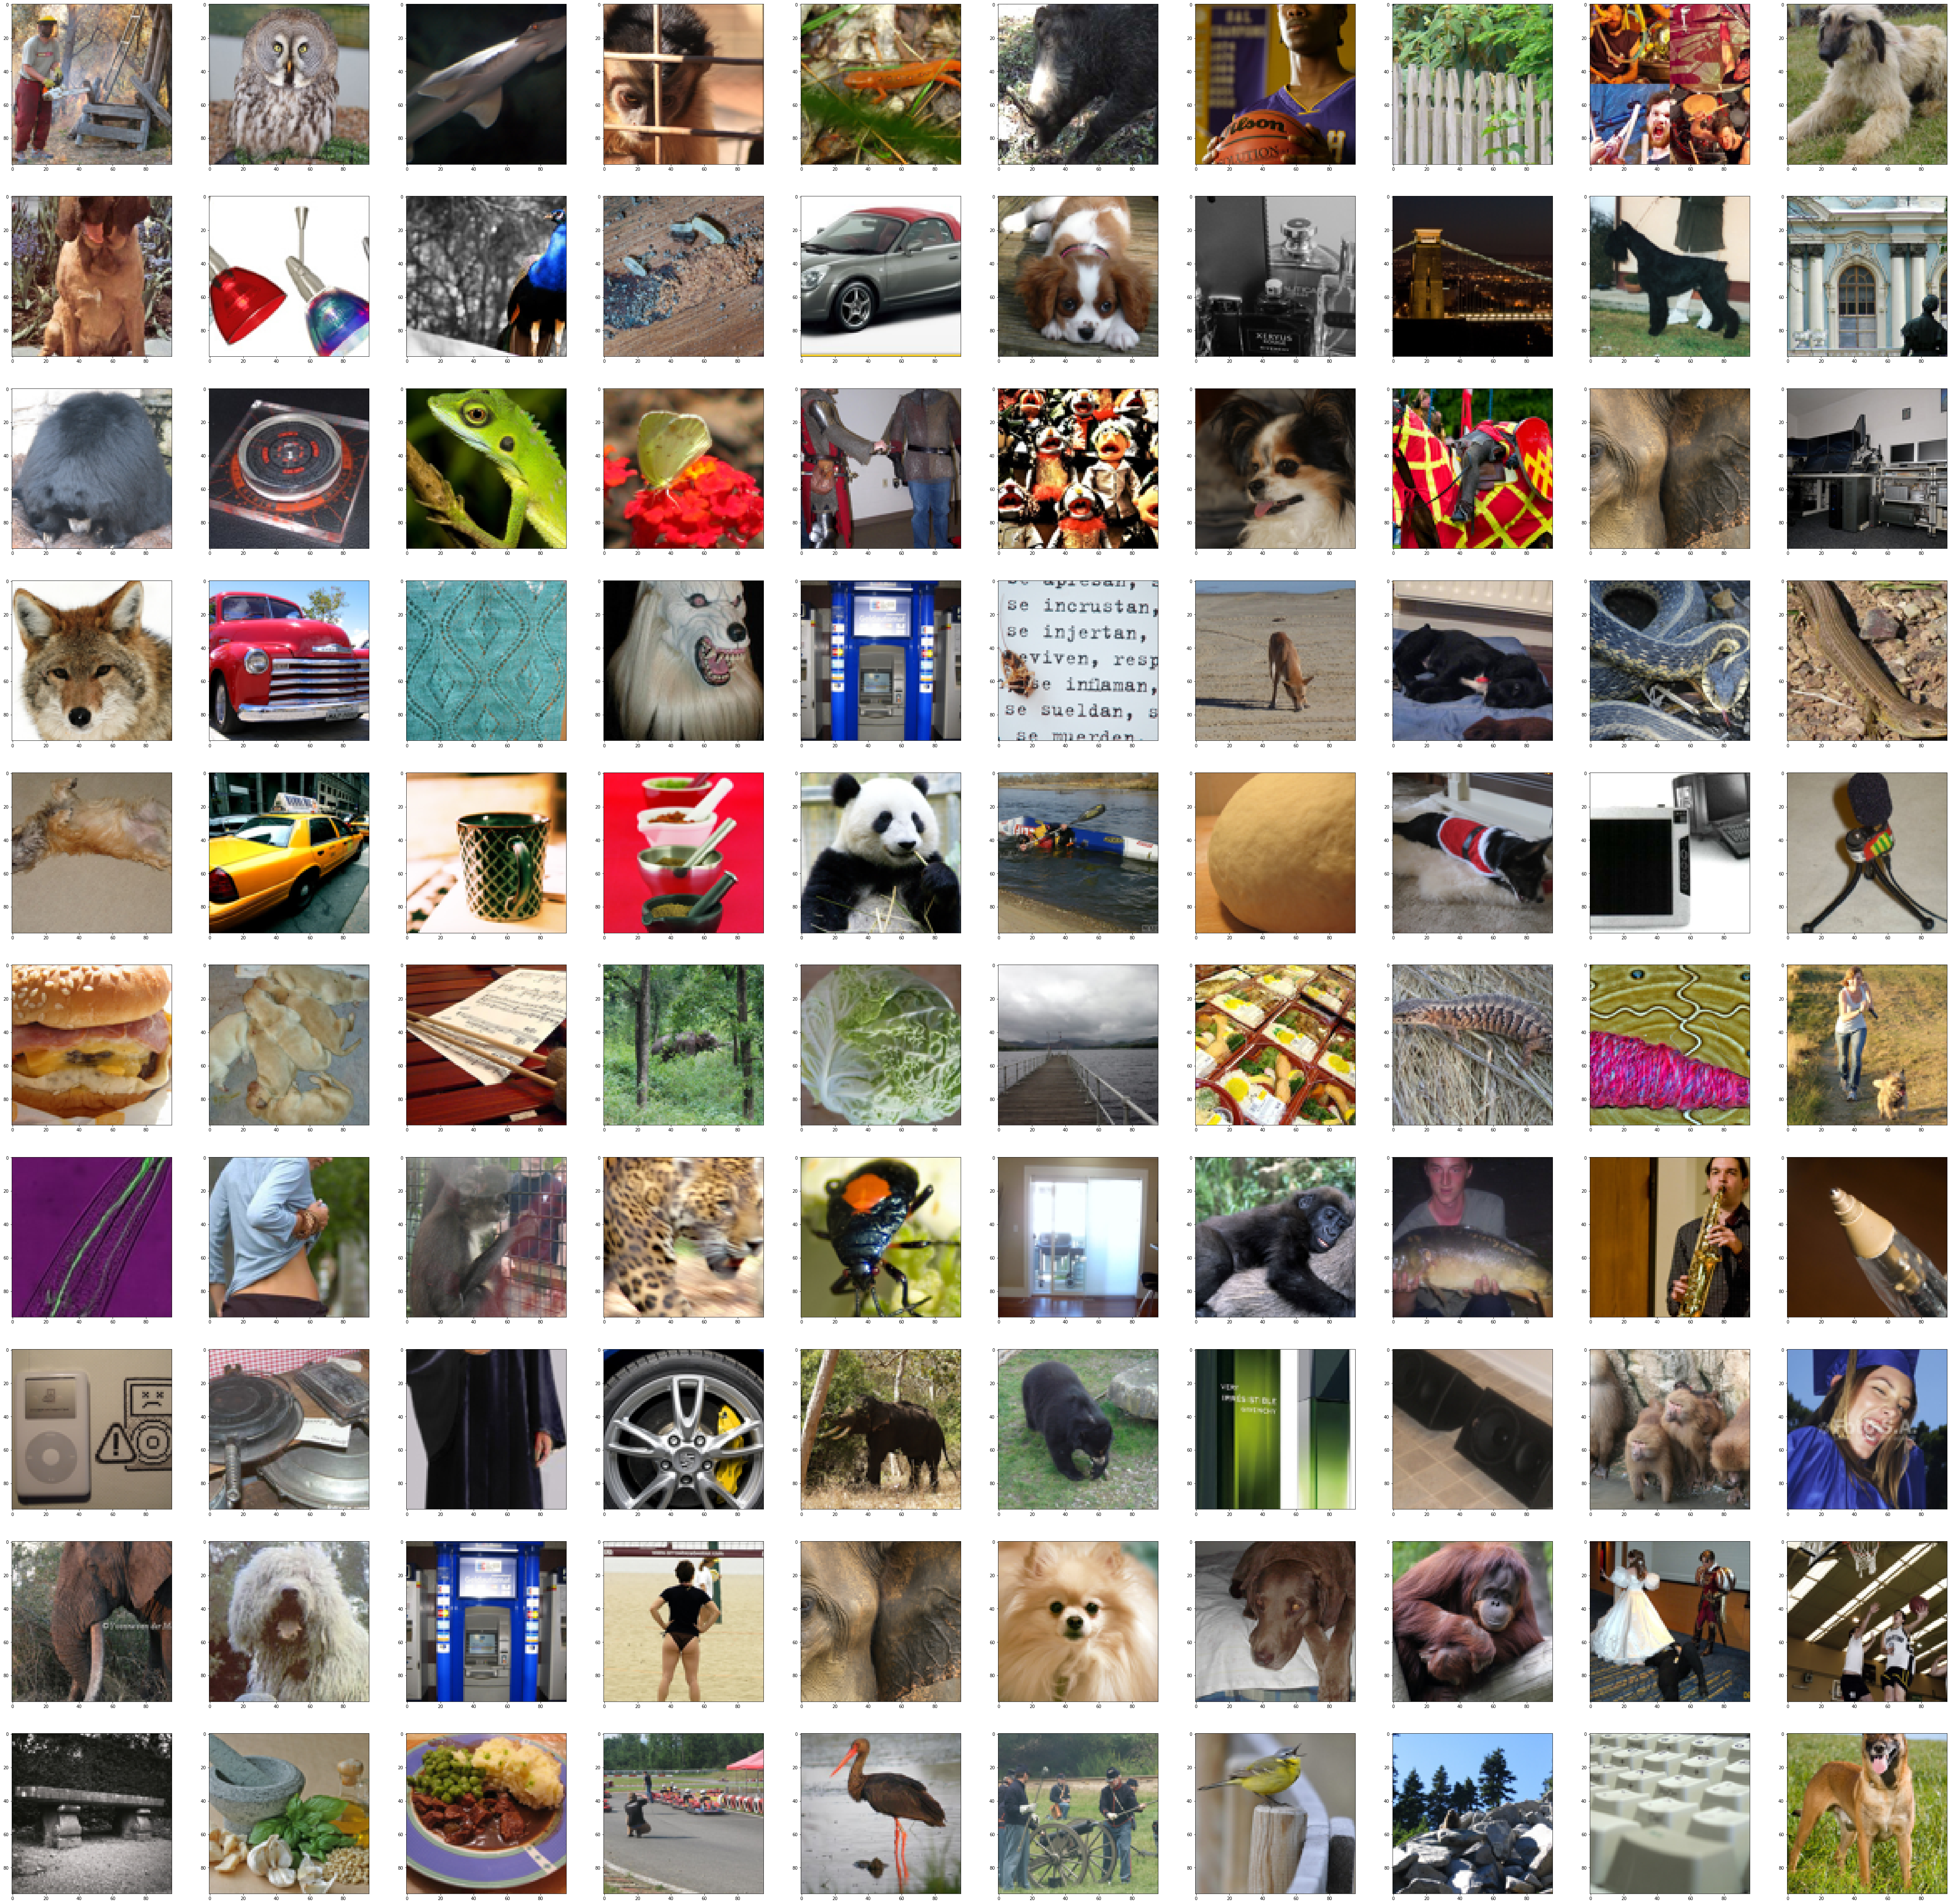

In [12]:
import random 
plt.figure(figsize=(80, 80));
start = 1
for i in range(start,start+100):
    image_ind = random.randint(0, 12800)
    image_ind =samples_10[image_ind]
    f = "./dataset/unlabeled/"+str(image_ind)+".png"
    img = Image.open(f).convert('RGB')
    plt.subplot(10, 10, i-start+1)
    plt.imshow(img)

In [ ]:
import csv
with open('bald.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(X)):
        writer.writerow([X[i],0])
